# Load Levels

In [1]:
levels = [open(f"levels/level{i+1}.txt", "r").readline().strip() for i in range(10)]

# Customize Game Class

In [17]:
from game import Game

RIGHT_DIRECT_MOVE = "0"
RIGHT_JUMP__MOVE = "1"
RIGHT_DODGE_MOVE = "2"

BLANKK = "_"
GOOMPA = "G"
LAKIPO = "L"
MUSHRM = "M"


class MyGame(Game):
    # modified score function
    def get_score(
        self,
        actions,
        step_score=1,
        honor_score=1,
        bonus_score=2,
        enemy_encounter_score=2,
        win_score=5,
        lose_penalty=0,
        jump_penalty=0.2,
        is_lose_seq_continue_accepted=True,
    ):
        current_level = self.levels[self.current_level_index]
        won = True
        score = 0  # previously named step
        for step in range(self.current_level_len - 1):
            current_step = current_level[step]
            if current_step == BLANKK and (
                step == 0 or actions[step - 1] != RIGHT_JUMP__MOVE
            ):
                score += step_score
            elif current_step == BLANKK and actions[step - 1] == RIGHT_JUMP__MOVE:
                score += step_score - jump_penalty
            # bonus encounter state
            elif current_step == MUSHRM and actions[step - 1] != RIGHT_JUMP__MOVE:
                score += bonus_score
            elif current_step == MUSHRM and actions[step - 1] == RIGHT_JUMP__MOVE:
                score += step_score
            # enemy encounter state
            elif current_step == GOOMPA and actions[step - 2] == RIGHT_JUMP__MOVE:
                score += step_score + enemy_encounter_score
            elif current_step == GOOMPA and actions[step - 1] == RIGHT_JUMP__MOVE:
                score += step_score
            elif current_step == LAKIPO and actions[step - 1] == RIGHT_DODGE_MOVE:
                score += step_score
            # lose state
            else:
                won = False
                score -= lose_penalty
                if is_lose_seq_continue_accepted:
                    continue
                else:
                    break
            # honorable win
            if won and actions[len(current_level) - 1] == RIGHT_JUMP__MOVE:
                score += honor_score

        return won, score + win_score if won else 0

    # bulk running utilities
    def get_score_for_next(self, move):
        self.load_next_level()
        return self.get_score(move)

    def get_score_for_each(self, move_list):
        return [self.get_score_for_next(move) for move in move_list]


# g = MyGame(levels)

# bulk running
# scores = [g.get_score_for_next("0000000000") for i in range(10)]
# scores = g.get_score_for_each(["0000000000"]*10)

# Initialization

In [45]:
import random


def generate_random_string(length, possible_actions="012"):
    """randomly generates a sequence of given possible_actions

    default actions express equal chance of presence for each action in random solution

    e.g. you can pass "0012" for double chance of direct move presence in random solution
    """
    return "".join(random.choice(possible_actions) for i in range(length))


INIT_POPULATION_SIZE = 200
population = [
    [generate_random_string(len(l)) for l in levels]
    for i in range(INIT_POPULATION_SIZE)
]

# Selection

In [48]:
def round_wheel_selection(inputs, scores):
    selected_inputs = []
    selected_scores = []
    points = [random.randint(0, sum(scores)) for i in range(inputs // 2)]
    progressive_sum = 0
    for i in range(len(inputs)):
        for point in points:
            if point >= progressive_sum and point < progressive_sum + scores[i]:
                selected_inputs.append(inputs[i])
                selected_scores.append(scores[i])
        progressive_sum += scores[i]
    return selected_inputs, selected_scores


def fitness_based_selection(inputs, scores):
    sorted_inputs, sorted_scores = zip(
        *sorted(list(zip(inputs, scores)), key=lambda x: x[1])
    )
    return sorted_inputs[: inputs // 2 + 1], sorted_scores[: sorted_scores // 2 + 1]

# Diagrams

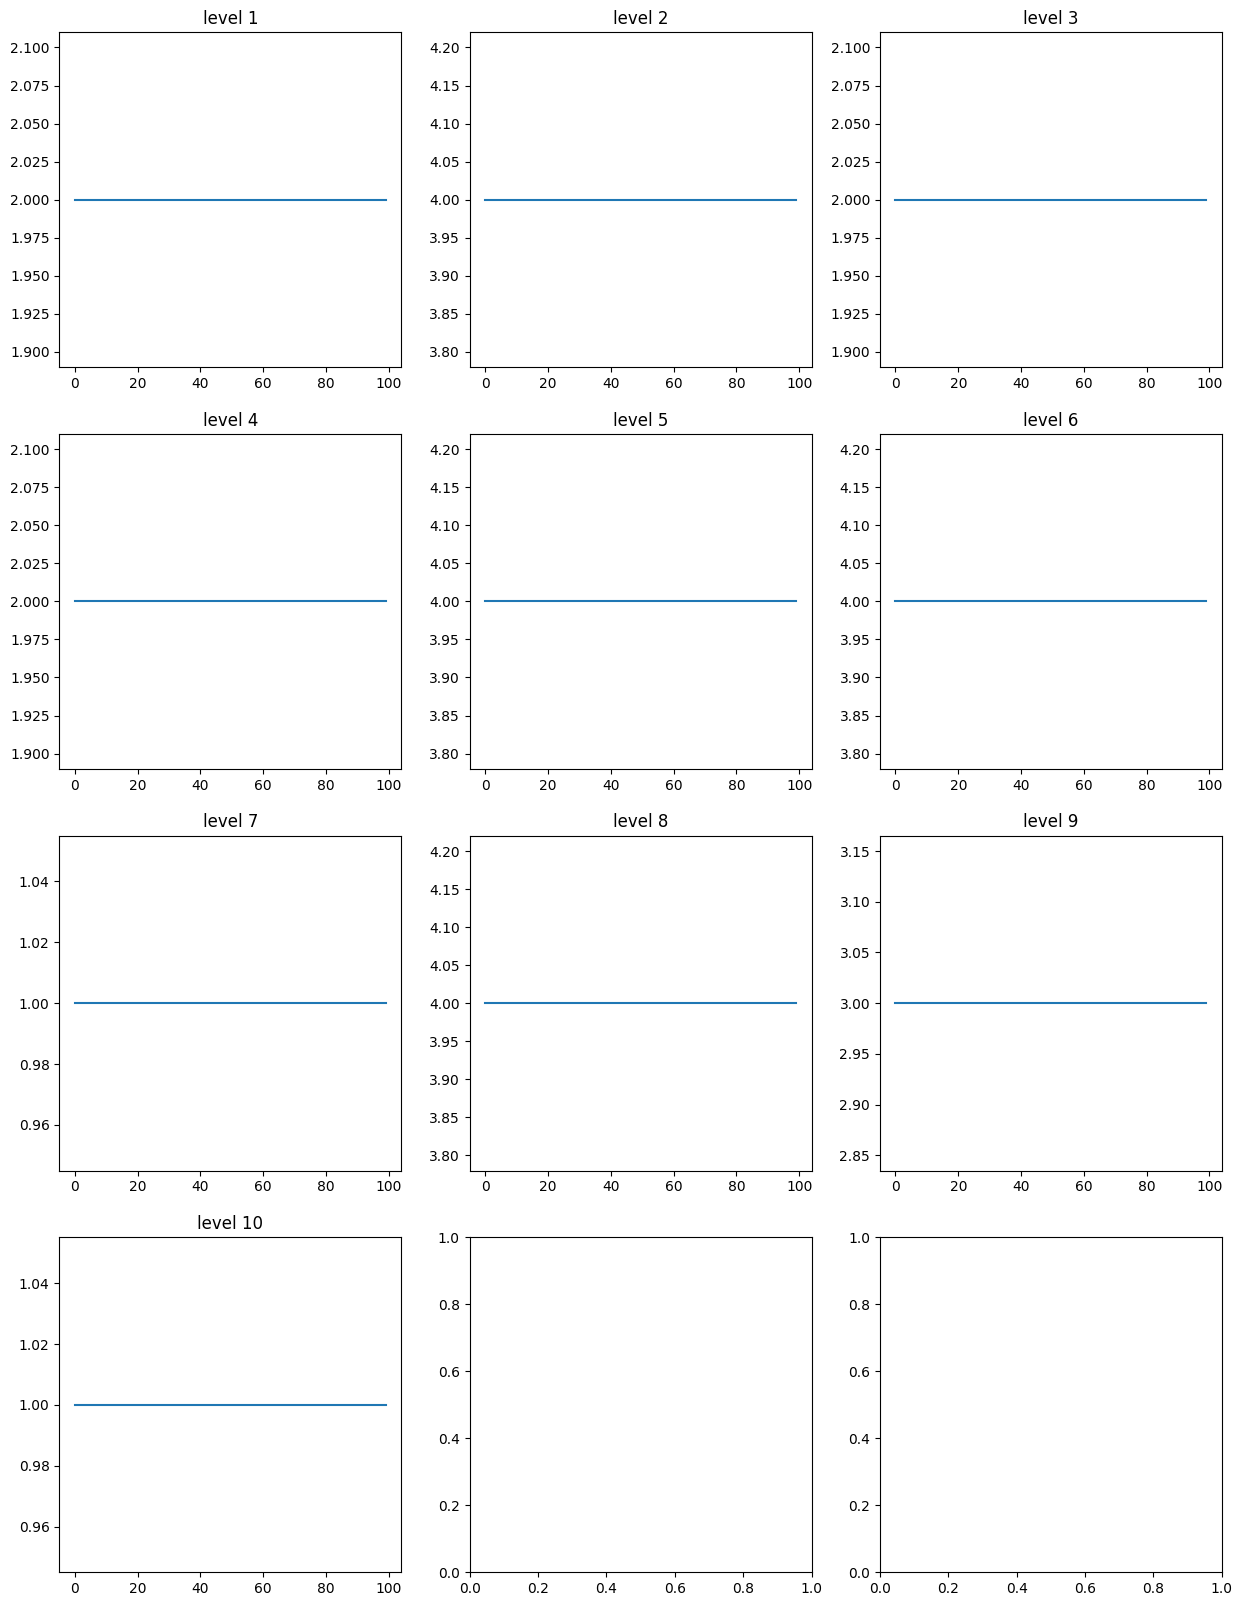

In [40]:
from matplotlib import pyplot as plt
import numpy as np

score_changes = np.array([scores] * 100)

fig, ax = plt.subplots(4, 3, figsize=(15, 20))

ln = 1
for j in range(4):
    for i in range(3):
        ax[j, i].plot(score_changes[:, ln - 1, 1])
        ax[j, i].set_title(f"level {ln}")
        ln += 1
        if ln > 10: break
plt.show()